# Time series classification on Starlight curves dataset

Goal of this project is to apply the most common time series classification (TSC) methods on a publicly available dataset out of Astronomy studies, namely the Starlight curves dataset, which can be downloaded <a href="http://www.timeseriesclassification.com/description.php?Dataset=StarlightCurves" target="_blank">here</a>.

The dataset consists of N = 9236 starlight curves. The brightness of celestial objects was recorded over time in a set of n = 1024 samples. There are three types of stars: Eclipsed Binaries (purple), Cepheids (blue) and RR Lyrae Variables (green). Our goal is to classify stars based on their brightness variation over time.

We used the standard train/test split but we used 10% of the training set for validation purposes. So to summarize following were the sizes of the data subsets for our experiments:

| Subset | Size |
| :--- | ---: |
| Train | 900 |
| Validation | 100 |
| Test | 8236 |


The model architectures we developed and tested were based on state-of-the-art TSC methods described in [1] and [2]. In particular, we measured classification performance of 4 different models:

1. Multi-layer Perceptron (MLP) - based on the architecture described in [2]
2. Single-layer LSTM (RNN and GRU classes are also available)
3. CNN - based on the architecture described in [1]
4. ResNet - based on the architecture described in [2]

***

Necessary imports

In [3]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import tqdm as tqdm_ 
from tqdm.notebook import tqdm # Overkill progress bars
from torchsummary import summary

from functools import partial

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from datetime import datetime

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("device:{}\n".format(device))
print("python:\n{}\n".format(sys.version))
print("torch=={}".format(torch.__version__))
print("numpy=={}".format(np.__version__))

print("tqdm=={}".format(tqdm_.__version__))
print("matplotlib=={}".format(matplotlib.__version__))

device:cpu

python:
3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]

torch==1.11.0+cpu
numpy==1.21.5
tqdm==4.64.0
matplotlib==3.5.1


## Data ingestion and preparation

In [4]:
df_train = pd.read_csv('StarLightCurves/StarLightCurves_TRAIN.txt', header=None,delim_whitespace=True)
df_test = pd.read_csv('StarLightCurves/StarLightCurves_TEST.txt', header=None, delim_whitespace=True)

In [5]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,3.0,0.537303,0.531103,0.528503,0.529403,0.533603,0.540903,0.551103,0.564003,0.579603,...,0.547103,0.546903,0.545903,0.543903,0.541003,0.537203,0.532303,0.526403,0.519503,0.511403
1,3.0,0.588398,0.593898,0.599098,0.604098,0.608798,0.613397,0.617797,0.622097,0.626097,...,0.228799,0.237399,0.246499,0.256199,0.266499,0.277399,0.288799,0.300899,0.313599,0.326899
2,1.0,-0.049900,-0.041500,-0.033400,-0.025600,-0.018100,-0.010800,-0.003800,0.003000,0.009600,...,-0.185601,-0.173801,-0.161601,-0.149201,-0.136401,-0.123201,-0.109701,-0.095901,-0.081701,-0.067100
3,3.0,1.337005,1.319805,1.302905,1.286305,1.270005,1.254005,1.238304,1.223005,1.208104,...,1.278905,1.288905,1.298505,1.307705,1.316505,1.324905,1.332805,1.340205,1.347005,1.353205
4,3.0,0.769801,0.775301,0.780401,0.785101,0.789401,0.793301,0.796801,0.799901,0.802601,...,0.740801,0.742401,0.744501,0.747301,0.750701,0.754801,0.759501,0.765001,0.771301,0.778401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.0,-0.751000,-0.749100,-0.747100,-0.745200,-0.743300,-0.741500,-0.739600,-0.737800,-0.735900,...,-0.770900,-0.768600,-0.766100,-0.763500,-0.760700,-0.757800,-0.754700,-0.751500,-0.748100,-0.744600
996,3.0,0.867600,0.860300,0.853300,0.846500,0.840100,0.834000,0.828100,0.822600,0.817400,...,0.845200,0.847500,0.849800,0.852100,0.854400,0.856800,0.859200,0.861700,0.864100,0.866600
997,1.0,0.087398,0.097398,0.107698,0.118298,0.129298,0.140398,0.151898,0.163498,0.175398,...,0.002598,0.012198,0.022098,0.032398,0.042898,0.053798,0.065098,0.076698,0.088698,0.101098
998,3.0,0.664799,0.654799,0.646099,0.638599,0.632299,0.627199,0.623099,0.619999,0.617899,...,0.699199,0.699299,0.698899,0.698099,0.696899,0.695299,0.693299,0.690799,0.687799,0.684399


We store the sequence length that is going to be used for data preparation

In [6]:
seq_length=df_train.iloc[:,1:].shape[1]
seq_length

1024

We prepare the set according to the shape train/test size, sequence length (24) and feature size i.e. 1 for univariate TS. This is the format required by RNN models. For the other models we need then to switch the format to:

In [7]:
X_train = df_train.iloc[:, 1:].values.reshape(-1,seq_length,1)
X_test = df_test.iloc[:, 1:].values.reshape(-1,seq_length,1)

We modify the labels to be 0, 1 and 2 instead of 1, 2 and 3 because our CrossEntropyLoss criterion requires classes indices to be in the range [0, C) where C is the number of classes.

In [8]:
y_train = df_train.iloc[:, 0].values-1
y_test = df_test.iloc[:, 0].values-1

In [9]:
y_test

array([1., 2., 2., ..., 0., 1., 2.])

We split the training set so that 10% of the data are dedicated to validation.

In [10]:
idx = np.arange(len(X_train))
train_idx, val_idx = train_test_split(idx, test_size=0.1)

In [11]:
train_ds = TensorDataset(torch.tensor(X_train[train_idx]).float(),torch.tensor(y_train[train_idx]).long())
val_ds = TensorDataset(torch.tensor(X_train[val_idx]).float(),torch.tensor(y_train[val_idx]).long())
test_ds = TensorDataset(torch.tensor(X_test).float(),torch.tensor(y_test).long())

In [12]:
X_train[:,:,0][0]

array([0.53730293, 0.53110294, 0.52850294, ..., 0.52640294, 0.51950294,
       0.51140294])

In [13]:
X_train.shape

(1000, 1024, 1)

We choose a **batch size** equal to 50. Given the **number of epochs** that we later set to 100, it will take 18 iterations to pass the entire training dataset made of 900 sequences to pass through the models. 

We could adapt these parameters depending on how the losses are changing as a function of the epochs. If we see that training is  completed, while the losses are still going down, this is probably an indication of underfitting and we could increase the number of epochs. On the contrary, if the losses are stabilizing or even increasing, then we are most likely overfitting.

We will see later how our traning process is behaving using these initial values for these parameters.

Actually a necessary step that we have not covered in this notebook is cross-validation. Optimal values of batch size and learning rate should typically be found in a cross-validation process. 

In [14]:
batch_size=50

In [15]:
train_loader = DataLoader(dataset=train_ds,
                          batch_size=batch_size, 
                          shuffle=False, drop_last = True)

val_loader = DataLoader(dataset=val_ds,
                          batch_size=batch_size, 
                          shuffle=False, drop_last = True)

test_loader = DataLoader(dataset=test_ds,
                          batch_size=batch_size, 
                          shuffle=False, drop_last = True)

Plot brightness samples of the three different star types

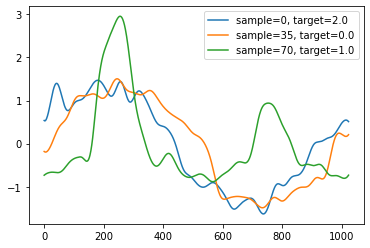

In [16]:
for i in range(0,71,35): 
    plt.plot(X_train[:,:,0][i],label="sample={}, target={}".format(i, y_train[i]))
plt.legend()

## Models definition

### MLP

The architecture described in [2] and represented in the figure below is implemented here. Note that eventually we removed the final softmax layer from the code because, when further studying the **CrossEntropyLoss** criterion documentation, we found out that the criterion combines  already a LogSoftMax operation together with NLLLoss. So applying it in the architecture would mean using it twice. In fact, when commenting out the SoftMax layer, performance classification increased significantly.

![Image file needs to be placed in the same working directory of the .ipynb](MLP.png)

In [19]:
class MLPModel (nn.Module):
    def __init__(self, seq_length, hidden_size, n_classes, drop_prob):
        super().__init__()
        self.input_size = seq_length
        self.hidden_size  = hidden_size
        self.dropout = nn.Dropout(drop_prob)        
        
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu1 = torch.nn.ReLU()
        self.dropout1 = nn.Dropout(drop_prob*2)
        
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.relu2 = torch.nn.ReLU()
        self.dropout2 = nn.Dropout(drop_prob*2)
        
        self.fc3 = torch.nn.Linear(self.hidden_size, n_classes)
        self.relu3 = torch.nn.ReLU()
        self.dropout3 = nn.Dropout(drop_prob*3)
        
        #self.softmax = torch.nn.Softmax(dim=0)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        hidden1 = self.dropout1(self.relu1(self.fc1(x)))
        hidden2 = self.dropout2(self.relu2(self.fc2(hidden1)))
        output = self.dropout3(self.relu3(self.fc3(hidden2)))
        prediction = output
        return prediction

### RNN, LSTM, GRU

In [20]:
class RNNModel (nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, n_classes=3, drop_prob=0): #input_size = number of features that in our case of univariate TS is equal to 1.
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers    
        self.rnn = nn.RNN(input_size,hidden_size,n_layers, dropout=drop_prob, batch_first=True)
        self.fc=nn.Linear(hidden_size, n_classes)
        self.softmax = torch.nn.Softmax(dim=0)
    
    def forward(self, inputs): #Input is a tensor with shape 24x1 in other words seq_length 24 x 1 feature. However I need to add batch_size first.
        #Initialization of state = h_0
        h_0 = torch.zeros(self.n_layers, inputs.size(0), self.hidden_size, device=device).requires_grad_()
        h_t, state = self.rnn(inputs)
        output = self.fc(h_t[:,-1,:]) #We take only the last element of the sequence h_t to make a prediction
        prediction = self.softmax(output)
        return prediction        
    

In [21]:
class LSTMModel (nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, n_classes=3, drop_prob=0): #input_size = number of features that in our case of univariate TS is equal to 1.
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers    
        self.lstm = nn.LSTM(input_size,hidden_size,n_layers, dropout=drop_prob, batch_first=True)
        self.fc=nn.Linear(hidden_size, n_classes)
        #self.softmax = torch.nn.Softmax(dim=0)
        #self.tanh = nn.Tanh()
    
    def forward(self, inputs): #Input is a tensor with shape 24x1 in other words seq_length 24 x 1 feature. However I need to add batch_size first.
        #Initialization of state = h_0, c_0
        state = (torch.zeros(self.n_layers, inputs.size(0), self.hidden_size, device=device).requires_grad_(),
                torch.zeros(self.n_layers, inputs.size(0), self.hidden_size, device=device).requires_grad_())
        h_t, state = self.lstm(inputs, state)
        output = self.fc(h_t[:,-1,:]) #We take only the last element of the sequence h_t to make a prediction
        #prediction = self.softmax(output)
        return output        
    

In [22]:
class GRUModel (nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, n_classes=3, drop_prob=0): #input_size = number of features that in our case of univariate TS is equal to 1.
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers    
        self.gru = nn.GRU(input_size,hidden_size,n_layers, dropout=drop_prob, batch_first=True)
        self.fc=nn.Linear(hidden_size, n_classes)
        self.softmax = torch.nn.Softmax(dim=0)
    
    def forward(self, inputs): #Input is a tensor with shape 24x1 in other words seq_length 24 x 1 feature. However I need to add batch_size first.
        #Initialization of state = h_0
        h_0 = torch.zeros(self.n_layers, inputs.size(0), self.hidden_size, device=device)
        h_t, state = self.gru(inputs)
        output = self.fc(h_t[:,-1,:]) #We take only the last element of the sequence h_t to make a prediction
        prediction = self.softmax(output)
        return prediction        
    

### CNN

The architecture we select is suggested in [1] and represented in the figure below with the difference that we apply it to our univariate time-series. 

It consists of two convolutional layers, each followed by a max pooling operation. Data are finally passed through two fully connected linear layers that eventually reduce the connections to the number of classes for the final classification. 

Important design parameters for the architecture are the number of convolutional filters together with their size in the initial two layers. In the final linear layers it is important then to decide how many nodes are used in the hidden layer.

![Image file needs to be placed in the same working directory of the .ipynb](CNN.png)

In [23]:
class CNNModel(nn.Module):
    def __init__(self, conv_filters, conv_filters2, conv_filter_size, num_units_fc):
        super(CNNModel, self).__init__()
        self.num_inputs_fc = conv_filters2*(int(((seq_length-conv_filter_size+1)/2-conv_filter_size+1)/2))

        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = conv_filters, 
                               kernel_size=conv_filter_size, padding = 0, stride = 1)
        self.max_pool = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(in_channels = conv_filters, out_channels = conv_filters2, 
                               kernel_size=conv_filter_size, padding = 0, stride = 1)
        self.max_pool2 = nn.MaxPool1d(2)
        self.fc = nn.Linear(self.num_inputs_fc, num_units_fc)
        self.out = nn.Linear(num_units_fc, n_classes) 

    def forward(self, x):
        #set_trace()
        x = x.view(-1, 1, seq_length)
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = x.view(-1, self.num_inputs_fc)
        x = torch.relu(self.fc(x))
        x = self.out(x)
        return x

### ResNet

The ResNet architecture implemented here is based on the one suggested in [2] and represented in the figure below.

![Image file needs to be placed in the same working directory of the .ipynb](ResNet.png)

In [24]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kss=[7, 5, 3], stride=1, padding=3):
        super(ResBlock, self).__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 
                               kernel_size=kss[0], padding = 3, stride = 1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()    
        )

        self.convblock2 = nn.Sequential(
            nn.Conv1d(out_channels, out_channels, 
                               kernel_size=kss[1], padding = 2, stride = 1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()    
        )

        self.convblock3 = nn.Sequential(
            nn.Conv1d(out_channels, out_channels, 
                               kernel_size=kss[2], padding = 1, stride = 1),
            nn.BatchNorm1d(out_channels), 
            nn.ReLU() 
        )


        #expand channels for the sum if necessary
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,stride=1),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()                

        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = x + self.shortcut(res)
        x = self.act(x)
        return x
    
class ResNetModel(nn.Module):
    def __init__(self, in_channels, mid_channels, num_pred_classes):
        super(ResNetModel, self).__init__()        
        kss=[7, 5, 3]        
        self.resblock1 = ResBlock(in_channels, mid_channels, kss=kss)
        self.resblock2 = ResBlock(mid_channels, mid_channels * 2, kss=kss)
        self.resblock3 = ResBlock(mid_channels * 2, mid_channels * 2, kss=kss)
        print (self.resblock3)
        self.gap = nn.AdaptiveAvgPool1d(1)
        print (self.gap)
        self.fc = nn.Linear(mid_channels * 2, num_pred_classes)
        self.softmax = torch.nn.Softmax(dim=1) 
        print (self.fc)

    def forward(self, x):
        x = x.view(-1, 1, seq_length)
        x = self.resblock1(x)        
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.gap(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

## Optimization class

Below is the optimization class that we use for hyperparameter optimization of the models described above. 

It is split into 4 functions: the "train" function that goes through over the train and validation data "n_epochs" times. For every batch an optimization step is applied and validated over the validation set ("train_step" function). In this step data are passed through the model, loss is measured, gradients are computed through backpropagation and finally parameters are updated.

Losses are plotted with the help of the "plot_losses" function. 

Finally, the "evaluate" function measures the performance of the model over train and test data.

In [21]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(yhat, y)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size=5, n_epochs=100, n_features=1):
        
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(yhat, y_val).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()
        
    def evaluate(self, test_loader, batch_size=5, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            total = 0
            correct = 0
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                _, predicted = torch.max(yhat.data, 1)
                predictions.append(predicted.cpu().detach().numpy())
                values.append(y_test.cpu().detach().numpy())
                total += y_test.size(0)
                correct += (predicted == y_test).sum().item()   
        print ("Accuracy of ", self.model, " : %.2f %%" % (100 * correct / total))
        print ("Correct : ", correct, "Total : ", total)
        return predictions, values

## Execution preparation

Function to select one of the classes/models above:

In [17]:
def get_model(model, model_params):
    models = {
        "mlp" : MLPModel,
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
        "cnn" : CNNModel,
        "resnet" : ResNetModel        
    }
    return models.get(model.lower())(**model_params)

Parameters setting used for all the models. We choose to have 100 epochs and a **learning rate** equal to 0.00001. This a quite low learning rate that implies a low convergence of the weights and that requires a not so low number of epochs. We use as well a very low **weight decay** in our optimizer that should help regularization.

Parameters like learning rate, batch size, weight decay should actually be optimized through a **tuning** process. With the help of the ray-tuner package, we set this up for the case of MLP. 

In [18]:
input_size = X_train.shape[-1]
n_classes=len(np.unique(y_train))
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

In [24]:
np.unique(y_train, return_counts=True)

(array([0., 1., 2.]), array([152, 275, 573]))

In [25]:
np.unique(y_test, return_counts=True)

(array([0., 1., 2.]), array([1177, 2305, 4754]))

## Hyper-parameter tuning for MLP using Ray Tune

Here we re-use most of the code found on the ray tune tutorial pages with only few adaptations. However, this implies a duplication of certain functions like the train and evaluate functions. Better integration of the ray-tune code with the existing train and evaluate functions would actually be required.

In [26]:
def train(config, checkpoint_dir=None, data_dir=None):

    model_params = {
                'seq_length': seq_length,
                'hidden_size' : config["hidden_size"],
                'n_classes' : 3,
                'drop_prob' : 0.1   
               }

    model = get_model('mlp', model_params)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)  
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainloader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_ds,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(100):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [27]:
def test_accuracy(net, device="cpu"):
    
    testloader = torch.utils.data.DataLoader(
        test_ds, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [28]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    data_dir = os.path.abspath("/home/jovyan/shared-data/")
    config = {
        "lr": tune.choice([1e-5, 1e-3,1e-1]),        
        "hidden_size": tune.choice([200,350,500]),
        "batch_size": tune.choice([10, 50, 100])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = MLPModel(seq_length,best_trial.config["hidden_size"],n_classes,drop_prob=0.1)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))

In [29]:
if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=0)

2022-04-29 13:16:35,793	INFO trial_runner.py:803 -- starting train_980e3_00000
2022-04-29 13:16:35,951	ERROR syncer.py:119 -- Log sync requires rsync to be installed.
2022-04-29 13:16:42,533	INFO trial_runner.py:803 -- starting train_980e3_00001


== Status ==
Current time: 2022-04-29 13:16:35 (running for 00:00:00.84)
Memory usage on this node: 40.8/220.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/8 CPUs, 0/1 GPUs, 0.0/57.22 GiB heap, 0.0/28.52 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/jovyan/ray_results/train_2022-04-29_13-16-35
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------+----------+----------------+--------------+---------------+-------+
| Trial name        | status   | loc            |   batch_size |   hidden_size |    lr |
|-------------------+----------+----------------+--------------+---------------+-------|
| train_980e3_00000 | RUNNING  | 10.1.0.103:501 |           50 |           350 | 1e-05 |
| train_980e3_00001 | PENDING  |                |           10 |           350 | 0.001 |
| train_980e3_00002 | PENDING  |                |           50 |           500 | 1e-05 |
| 

2022-04-29 13:16:49,140	INFO trial_runner.py:803 -- starting train_980e3_00002


== Status ==
Current time: 2022-04-29 13:16:42 (running for 00:00:07.45)
Memory usage on this node: 41.1/220.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 4.0/8 CPUs, 0/1 GPUs, 0.0/57.22 GiB heap, 0.0/28.52 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/jovyan/ray_results/train_2022-04-29_13-16-35
Number of trials: 10/10 (8 PENDING, 2 RUNNING)
+-------------------+----------+----------------+--------------+---------------+-------+
| Trial name        | status   | loc            |   batch_size |   hidden_size |    lr |
|-------------------+----------+----------------+--------------+---------------+-------|
| train_980e3_00000 | RUNNING  | 10.1.0.103:501 |           50 |           350 | 1e-05 |
| train_980e3_00001 | RUNNING  | 10.1.0.103:536 |           10 |           350 | 0.001 |
| train_980e3_00002 | PENDING  |                |           50 |           500 | 1e-05 |
| 

2022-04-29 13:16:55,730	INFO trial_runner.py:803 -- starting train_980e3_00003


== Status ==
Current time: 2022-04-29 13:16:49 (running for 00:00:14.07)
Memory usage on this node: 41.5/220.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 6.0/8 CPUs, 0/1 GPUs, 0.0/57.22 GiB heap, 0.0/28.52 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/jovyan/ray_results/train_2022-04-29_13-16-35
Number of trials: 10/10 (7 PENDING, 3 RUNNING)
+-------------------+----------+----------------+--------------+---------------+-------+
| Trial name        | status   | loc            |   batch_size |   hidden_size |    lr |
|-------------------+----------+----------------+--------------+---------------+-------|
| train_980e3_00000 | RUNNING  | 10.1.0.103:501 |           50 |           350 | 1e-05 |
| train_980e3_00001 | RUNNING  | 10.1.0.103:536 |           10 |           350 | 0.001 |
| train_980e3_00002 | RUNNING  | 10.1.0.103:798 |           50 |           500 | 1e-05 |
| 

2022-04-29 13:17:03,179	INFO trial_runner.py:803 -- starting train_980e3_00004
2022-04-29 13:17:03,240	INFO trial_runner.py:803 -- starting train_980e3_00005


Result for train_980e3_00003:
  accuracy: 0.66
  date: 2022-04-29_13-17-03
  done: true
  experiment_id: cc580c4558004c7f9061e4fa61626e0f
  hostname: jupyter-gianluca-20colangelo
  iterations_since_restore: 2
  loss: 0.6033749580383301
  node_ip: 10.1.0.103
  pid: 1074
  should_checkpoint: true
  time_since_restore: 1.3377048969268799
  time_this_iter_s: 0.6712343692779541
  time_total_s: 1.3377048969268799
  timestamp: 1651238223
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 980e3_00003
  warmup_time: 0.004043102264404297
  


2022-04-29 13:17:05,180	INFO trial_runner.py:803 -- starting train_980e3_00006


Result for train_980e3_00002:
  accuracy: 0.62
  date: 2022-04-29_13-17-07
  done: false
  experiment_id: 92e1accef7de4c249b38d5b360832e38
  hostname: jupyter-gianluca-20colangelo
  iterations_since_restore: 9
  loss: 0.643066942691803
  node_ip: 10.1.0.103
  pid: 798
  should_checkpoint: true
  time_since_restore: 11.937806844711304
  time_this_iter_s: 0.6363670825958252
  time_total_s: 11.937806844711304
  timestamp: 1651238227
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 980e3_00002
  warmup_time: 0.003976583480834961
  
== Status ==
Current time: 2022-04-29 13:17:07 (running for 00:00:32.56)
Memory usage on this node: 41.2/220.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.6599599421024323 | Iter 4.000: -0.49694211781024933 | Iter 2.000: -0.6014381051063538 | Iter 1.000: -0.7161381393671036
Resources requested: 8.0/8 CPUs, 0/1 GPUs, 0.0/57.22 GiB heap, 0.0/28.52 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/jovyan/ray_result

2022-04-29 13:17:13,181	INFO trial_runner.py:803 -- starting train_980e3_00007
2022-04-29 13:17:13,226	INFO trial_runner.py:803 -- starting train_980e3_00008


Result for train_980e3_00005:
  accuracy: 0.64
  date: 2022-04-29_13-17-13
  done: true
  experiment_id: b520b0e085574a5bb64589cbef1c8d5b
  hostname: jupyter-gianluca-20colangelo
  iterations_since_restore: 2
  loss: 0.6022040545940399
  node_ip: 10.1.0.103
  pid: 2038
  should_checkpoint: true
  time_since_restore: 2.615435838699341
  time_this_iter_s: 1.8923532962799072
  time_total_s: 2.615435838699341
  timestamp: 1651238233
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 980e3_00005
  warmup_time: 0.0055387020111083984
  
Result for train_980e3_00002:
  accuracy: 0.61
  date: 2022-04-29_13-17-13
  done: true
  experiment_id: 92e1accef7de4c249b38d5b360832e38
  hostname: jupyter-gianluca-20colangelo
  iterations_since_restore: 10
  loss: 0.6364166140556335
  node_ip: 10.1.0.103
  pid: 798
  should_checkpoint: true
  time_since_restore: 17.46670937538147
  time_this_iter_s: 5.528902530670166
  time_total_s: 17.46670937538147
  timestamp: 1651238233
  timesteps_since_

2022-04-29 13:17:15,181	INFO trial_runner.py:803 -- starting train_980e3_00009


== Status ==
Current time: 2022-04-29 13:17:20 (running for 00:00:45.11)
Memory usage on this node: 41.8/220.2 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.6599599421024323 | Iter 4.000: -0.49694211781024933 | Iter 2.000: -0.6022040545940399 | Iter 1.000: -0.7083814144134521
Resources requested: 6.0/8 CPUs, 0/1 GPUs, 0.0/57.22 GiB heap, 0.0/28.52 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /home/jovyan/ray_results/train_2022-04-29_13-16-35
Number of trials: 10/10 (3 RUNNING, 7 TERMINATED)
+-------------------+------------+-----------------+--------------+---------------+-------+----------+------------+----------------------+
| Trial name        | status     | loc             |   batch_size |   hidden_size |    lr |     loss |   accuracy |   training_iteration |
|-------------------+------------+-----------------+--------------+---------------+-------+----------+------------+----------------------|
| train_980e3_00007 | RUNNING    | 10.1.0.103:4888 |   

2022-04-29 13:17:22,722	INFO tune.py:702 -- Total run time: 47.80 seconds (47.49 seconds for the tuning loop).


Best trial config: {'lr': 1e-05, 'hidden_size': 500, 'batch_size': 50}
Best trial final validation loss: 0.6022040545940399
Best trial final validation accuracy: 0.64
Best trial test set accuracy: 0.6387809616318602


So according to the outcome of the tuning process the combination of learning rate = 1e-5, hidden_size = 500 and batch size = 50 is the best possible combination in this case. Of course for simplicity reasons we used only 10 trials and 10 epochs that might have to be modified but this is good enough for the scope of this exercise.

## Training and testing of the models

### MLP

In line with the tuning process above we assign the optimal parameters. Note that in [2] the hidden size was set to 500.

In [30]:
hidden_size = 500
drop_prob = 0.1
learning_rate=1e-5

model_params = {
                'seq_length': seq_length,
                'hidden_size' : hidden_size,
                'n_classes' : n_classes,
                'drop_prob' : drop_prob   
               }

model = get_model('mlp', model_params).to(device)

Structure of the model with the indication of the trainable parmeters that for MLP amount to 764K

In [31]:
summary(model,input_size=(1024, 1),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                 [50, 1024]               0
            Linear-2                  [50, 500]         512,500
              ReLU-3                  [50, 500]               0
           Dropout-4                  [50, 500]               0
            Linear-5                  [50, 500]         250,500
              ReLU-6                  [50, 500]               0
           Dropout-7                  [50, 500]               0
            Linear-8                    [50, 3]           1,503
              ReLU-9                    [50, 3]               0
          Dropout-10                    [50, 3]               0
Total params: 764,503
Trainable params: 764,503
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 1.54
Params size (MB): 2.92
Estimated T

#### MLP training cycle

The loss function we use for the whole notebook is the **cross-entropy loss**, while we take **Adam** as an optimizer.

[1/100] Training loss: 1.0768	 Validation loss: 1.0132
[2/100] Training loss: 0.9839	 Validation loss: 0.9061
[3/100] Training loss: 0.8907	 Validation loss: 0.8128
[4/100] Training loss: 0.8295	 Validation loss: 0.7386
[5/100] Training loss: 0.7676	 Validation loss: 0.6815
[6/100] Training loss: 0.7488	 Validation loss: 0.6374
[7/100] Training loss: 0.7229	 Validation loss: 0.6052
[8/100] Training loss: 0.7139	 Validation loss: 0.5803
[9/100] Training loss: 0.7085	 Validation loss: 0.5600
[10/100] Training loss: 0.6689	 Validation loss: 0.5416
[50/100] Training loss: 0.6101	 Validation loss: 0.3872
[100/100] Training loss: 0.5974	 Validation loss: 0.3632


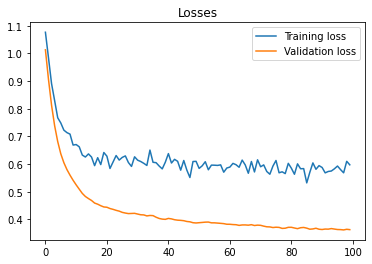

In [32]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=seq_length)
opt.plot_losses()

The model learns well in the first 10-20 epochs. After 20 epochs the loss flattens out both for training and validation set. Note that the validation set seems to be easier to predict than the training. The fact that the validation curve is lower than the training curve might be an indication that the validation set is not representative, not big enough and we might need to extend it.

#### MLP performance on training set

In [33]:
predictions, values = opt.evaluate(train_loader, batch_size=batch_size, n_features=seq_length)

Accuracy of  MLPModel(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=500, out_features=3, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.30000000000000004, inplace=False)
)  : 86.56 %
Correct :  779 Total :  900


In [34]:
print(classification_report(np.concatenate(values).ravel(), np.concatenate(predictions).ravel()))
confusion_matrix(np.concatenate(values).ravel(), np.concatenate(predictions).ravel())

              precision    recall  f1-score   support

           0       0.84      0.15      0.26       138
           1       1.00      1.00      1.00       248
           2       0.81      0.99      0.89       514

    accuracy                           0.87       900
   macro avg       0.88      0.71      0.72       900
weighted avg       0.87      0.87      0.83       900



array([[ 21,   0, 117],
       [  0, 248,   0],
       [  4,   0, 510]])

#### MLP performance on testing set 

In [35]:
predictions, values = opt.evaluate(test_loader, batch_size=batch_size, n_features=seq_length)

Accuracy of  MLPModel(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=500, out_features=3, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.30000000000000004, inplace=False)
)  : 86.44 %
Correct :  7088 Total :  8200


In [36]:
print(classification_report(np.concatenate(values).ravel(), np.concatenate(predictions).ravel()))
confusion_matrix(np.concatenate(values).ravel(), np.concatenate(predictions).ravel())

              precision    recall  f1-score   support

           0       0.66      0.11      0.19      1172
           1       1.00      1.00      1.00      2295
           2       0.82      0.98      0.89      4733

    accuracy                           0.86      8200
   macro avg       0.82      0.70      0.70      8200
weighted avg       0.85      0.86      0.82      8200



array([[ 133,    2, 1037],
       [   0, 2293,    2],
       [  69,    2, 4662]])

Looking at the very close accuracy measured on the training and testing sets we can say that we are certainly not overfitting.

Note that one of the class (1) is very clearly separable from the others while the other are easily mixed up. In particular, class 0 shows the poorer precision and recall performance, being easily confused with class 2.

Finally comparing the performance of our model with the one documented in [2] in which Adadelta, an adaptive learning rate method, is used as an optimizer, we actually see that our error rate is ~ 7% higher. This means that indeed we have room to improve our model. Without changing the optimizer we could review our hyper-parameters tuning process and choose a better combination of the parameters. 

### LSTM

LSTM-specific parameter definition. We decide to set the hidden size of LSTM to 128.

In [37]:
hidden_size = 128
n_layers = 1
drop_prob = 0

model_params = {'input_size': input_size,
                'hidden_size' : hidden_size,
                'n_layers' : n_layers,
                'n_classes' : n_classes,
                'drop_prob' : drop_prob}

model = get_model('lstm', model_params).to(device)

#### LSTM training cycle

In [38]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print ("Number of trainable parameters for our LSTM model : ", params)

Number of trainable parameters for our LSTM model :  67459


[1/100] Training loss: 1.0729	 Validation loss: 1.0699
[2/100] Training loss: 1.0713	 Validation loss: 1.0682
[3/100] Training loss: 1.0696	 Validation loss: 1.0664
[4/100] Training loss: 1.0679	 Validation loss: 1.0647
[5/100] Training loss: 1.0663	 Validation loss: 1.0629
[6/100] Training loss: 1.0646	 Validation loss: 1.0612
[7/100] Training loss: 1.0630	 Validation loss: 1.0594
[8/100] Training loss: 1.0613	 Validation loss: 1.0577
[9/100] Training loss: 1.0597	 Validation loss: 1.0559
[10/100] Training loss: 1.0580	 Validation loss: 1.0542
[50/100] Training loss: 0.7804	 Validation loss: 0.7590
[100/100] Training loss: 0.5890	 Validation loss: 0.5564


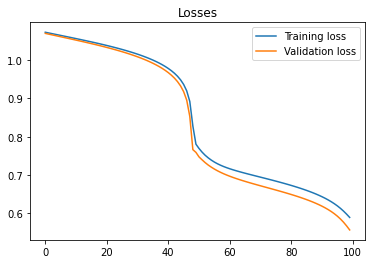

In [39]:
loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_size)
opt.plot_losses()

The shape of the loss curve is quite interesting. What we see in fact is that in the first 40 epochs the learning is extremely slow. After that the loss drops suddenly and keeps on dropping at a good rate even at later epochs.

The model has not learned enough and it is probably underfitting. Probably the learning process stopped prematurely. We conclude that it would certainly benefit from a higher learning rate or an increased number of epochs.

#### LSTM performance on training set

In [40]:
predictions, values = opt.evaluate(train_loader, batch_size=batch_size, n_features=input_size)

Accuracy of  LSTMModel(
  (lstm): LSTM(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)  : 79.56 %
Correct :  716 Total :  900


In [41]:
print(classification_report(np.concatenate(values).ravel(), np.concatenate(predictions).ravel()))
confusion_matrix(np.concatenate(values).ravel(), np.concatenate(predictions).ravel())

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.81      0.98      0.89       248
           2       0.79      0.92      0.85       514

    accuracy                           0.80       900
   macro avg       0.53      0.63      0.58       900
weighted avg       0.67      0.80      0.73       900



/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[  0,  16, 122],
       [  0, 243,   5],
       [  0,  41, 473]])

#### LSTM performance on testing set

In [42]:
predictions, values = opt.evaluate(test_loader, batch_size=batch_size, n_features=input_size)

Accuracy of  LSTMModel(
  (lstm): LSTM(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)  : 80.74 %
Correct :  6621 Total :  8200


In [43]:
print(classification_report(np.concatenate(values).ravel(), np.concatenate(predictions).ravel()))
confusion_matrix(np.concatenate(values).ravel(), np.concatenate(predictions).ravel())

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1172
           1       0.81      0.98      0.89      2295
           2       0.81      0.92      0.86      4733

    accuracy                           0.81      8200
   macro avg       0.54      0.63      0.58      8200
weighted avg       0.69      0.81      0.75      8200



/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[   0,  173,  999],
       [   0, 2253,   42],
       [   0,  365, 4368]])

The accuracy on the testing set is similar to the one on the training set actually even slightly higher. What is strange is that the model is not able to detect class 0 at all. If we applied a Softmax layer on the model output then class 0 would be detected but strangely enough accuracy would drop by 10%. For the fact previously mentioned that CrossEntropyLoss already implies a SoftMax calculation, we actually decided to remove that layer.

Also here a tuning of the hyper-parameters used would be required.

### CNN

CNN-specific parameter setting. In comparison to what was recommended in [1] we increased the number of filters from (6, 12) to (32, 64). With (6, 12) like in the LSTM case, class 0 is not detected. Increasing the number of filters improved the class-0 detection capabilities.

Number of filters would be an excellent parameter to give as an input to Ray Tuner. 

In [44]:
conv_filters = 32
conv_filters2 = 64
conv_filter_size = 7
num_units_fc = 50

drop_prob = 0

model_params = {
    'conv_filters': conv_filters,
    'conv_filters2' : conv_filters2,
    'conv_filter_size' : conv_filter_size,
    'num_units_fc' : num_units_fc
}

model = get_model('cnn', model_params).to(device)

In [45]:
summary(model,input_size=(1024, 1),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [50, 32, 1018]             256
         MaxPool1d-2              [50, 32, 509]               0
            Conv1d-3              [50, 64, 503]          14,400
         MaxPool1d-4              [50, 64, 251]               0
            Linear-5                   [50, 50]         803,250
            Linear-6                    [50, 3]             153
Total params: 818,059
Trainable params: 818,059
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 37.07
Params size (MB): 3.12
Estimated Total Size (MB): 40.38
----------------------------------------------------------------


#### CNN training cycle

[1/100] Training loss: 0.9800	 Validation loss: 0.8534
[2/100] Training loss: 0.7554	 Validation loss: 0.6505
[3/100] Training loss: 0.5885	 Validation loss: 0.5277
[4/100] Training loss: 0.4873	 Validation loss: 0.4560
[5/100] Training loss: 0.4271	 Validation loss: 0.4165
[6/100] Training loss: 0.3935	 Validation loss: 0.3923
[7/100] Training loss: 0.3728	 Validation loss: 0.3758
[8/100] Training loss: 0.3591	 Validation loss: 0.3641
[9/100] Training loss: 0.3495	 Validation loss: 0.3555
[10/100] Training loss: 0.3420	 Validation loss: 0.3477
[50/100] Training loss: 0.2837	 Validation loss: 0.2783
[100/100] Training loss: 0.2510	 Validation loss: 0.2340


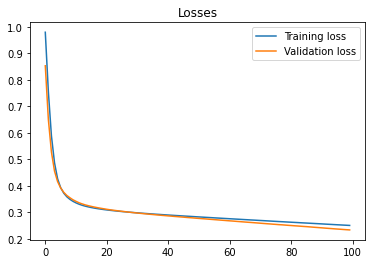

In [46]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_size)
opt.plot_losses()

In this case the loss on the training data set goes down very rapidly for about 10 epochs and then tend to flatten out even if continue a slow descent. Very similar behaviour happens on the validation set. This means that we have not reached a stage of overfitting. Actually the learning curve has almost an ideal shape.

#### CNN performance on training set

In [47]:
predictions, values = opt.evaluate(train_loader, batch_size=batch_size, n_features=seq_length)

Accuracy of  CNNModel(
  (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(1,))
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (max_pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=16064, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=3, bias=True)
)  : 87.67 %
Correct :  789 Total :  900


In [48]:
print(classification_report(np.concatenate(values).ravel(), np.concatenate(predictions).ravel()))
confusion_matrix(np.concatenate(values).ravel(), np.concatenate(predictions).ravel())

              precision    recall  f1-score   support

           0       0.75      0.29      0.42       138
           1       1.00      1.00      1.00       248
           2       0.84      0.97      0.90       514

    accuracy                           0.88       900
   macro avg       0.86      0.75      0.77       900
weighted avg       0.87      0.88      0.85       900



array([[ 40,   0,  98],
       [  0, 248,   0],
       [ 13,   0, 501]])

#### CNN performance on testing set

In [49]:
predictions, values = opt.evaluate(test_loader, batch_size=batch_size, n_features=input_size)

Accuracy of  CNNModel(
  (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(1,))
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (max_pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=16064, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=3, bias=True)
)  : 86.06 %
Correct :  7057 Total :  8200


In [50]:
print(classification_report(np.concatenate(values).ravel(), np.concatenate(predictions).ravel()))
confusion_matrix(np.concatenate(values).ravel(), np.concatenate(predictions).ravel())

              precision    recall  f1-score   support

           0       0.55      0.20      0.30      1172
           1       0.99      1.00      1.00      2295
           2       0.83      0.96      0.89      4733

    accuracy                           0.86      8200
   macro avg       0.79      0.72      0.73      8200
weighted avg       0.84      0.86      0.83      8200



array([[ 239,    3,  930],
       [   2, 2290,    3],
       [ 196,    9, 4528]])

The performance on the testing set is only 1% lower than on the training set. Increasing the number of filters would probably improve further the accuracy of the model and also the ability to detect more precisely class 0 (precision and recall). Again something to be tuned with the help of Ray Tuner.

### ResNet

ResNet-specific parameter settings

In [25]:
conv_filters=64
drop_prob = 0

model_params = {'in_channels': input_size,
                'mid_channels' : conv_filters,
                'num_pred_classes' : n_classes
               }

model = get_model('resnet', model_params).to(device)

ResBlock(
  (convblock1): Sequential(
    (0): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2): Sequential(
    (0): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock3): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (shortcut): Sequential()
  (act): ReLU()
)
AdaptiveAvgPool1d(output_size=1)
Linear(in_features=128, out_features=3, bias=True)


In [26]:
summary(model,input_size=(1024, 1),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [50, 64, 1024]             512
       BatchNorm1d-2             [50, 64, 1024]             128
              ReLU-3             [50, 64, 1024]               0
            Conv1d-4             [50, 64, 1024]          20,544
       BatchNorm1d-5             [50, 64, 1024]             128
              ReLU-6             [50, 64, 1024]               0
            Conv1d-7             [50, 64, 1024]          12,352
       BatchNorm1d-8             [50, 64, 1024]             128
              ReLU-9             [50, 64, 1024]               0
           Conv1d-10             [50, 64, 1024]             128
      BatchNorm1d-11             [50, 64, 1024]             128
             ReLU-12             [50, 64, 1024]               0
         ResBlock-13             [50, 64, 1024]               0
           Conv1d-14            [50, 12

#### ResNet training cycle

[1/100] Training loss: 0.8791	 Validation loss: 1.0000
[2/100] Training loss: 0.6803	 Validation loss: 0.7728
[3/100] Training loss: 0.5899	 Validation loss: 0.5826
[4/100] Training loss: 0.5369	 Validation loss: 0.5035
[5/100] Training loss: 0.5020	 Validation loss: 0.4578
[6/100] Training loss: 0.4766	 Validation loss: 0.4322
[7/100] Training loss: 0.4563	 Validation loss: 0.4162
[8/100] Training loss: 0.4386	 Validation loss: 0.4022
[9/100] Training loss: 0.4215	 Validation loss: 0.3889
[10/100] Training loss: 0.4046	 Validation loss: 0.3750
[50/100] Training loss: 0.1936	 Validation loss: 0.1477
[100/100] Training loss: 0.1282	 Validation loss: 0.1042


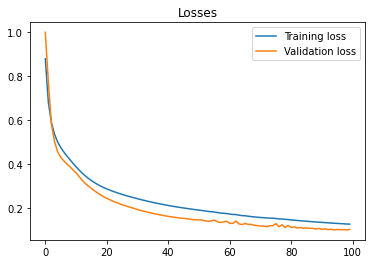

In [53]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_size)
opt.plot_losses()

The loss curve show an excellent decreasing shape for all the epochs on both the training and validation set. Only towards the last epochs the validation curve small signs of swinging. This shows that we have probably learned everything we could.

#### ResNet performance on training set

In [54]:
predictions, values = opt.evaluate(train_loader, batch_size=batch_size, n_features=seq_length)

Accuracy of  ResNetModel(
  (resblock1): ResBlock(
    (convblock1): Sequential(
      (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock2): Sequential(
      (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock3): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act): ReLU()
  )
  (resblock2): ResBlock(
    (convblock1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(7,),

In [55]:
print(classification_report(np.concatenate(values).ravel(), np.concatenate(predictions).ravel()))
confusion_matrix(np.concatenate(values).ravel(), np.concatenate(predictions).ravel())

              precision    recall  f1-score   support

           0       1.00      0.80      0.89       138
           1       1.00      1.00      1.00       248
           2       0.95      1.00      0.97       514

    accuracy                           0.97       900
   macro avg       0.98      0.93      0.95       900
weighted avg       0.97      0.97      0.97       900



array([[111,   0,  27],
       [  0, 247,   1],
       [  0,   0, 514]])

#### ResNet performance on testing set

In [56]:
predictions, values = opt.evaluate(test_loader, batch_size=batch_size, n_features=input_size)

Accuracy of  ResNetModel(
  (resblock1): ResBlock(
    (convblock1): Sequential(
      (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock2): Sequential(
      (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock3): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act): ReLU()
  )
  (resblock2): ResBlock(
    (convblock1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(7,),

In [57]:
print(classification_report(np.concatenate(values).ravel(), np.concatenate(predictions).ravel()))
confusion_matrix(np.concatenate(values).ravel(), np.concatenate(predictions).ravel())

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1172
           1       1.00      0.99      0.99      2295
           2       0.95      1.00      0.97      4733

    accuracy                           0.96      8200
   macro avg       0.98      0.92      0.95      8200
weighted avg       0.97      0.96      0.96      8200



array([[ 921,    0,  251],
       [   0, 2273,   22],
       [  12,    2, 4719]])

The performance of the ResNet is actually the best among the 4 models and almost in line with the measurements described in [2]. No big difference between the training and testing performance meaning that overfit did not really hit.

## Final considerations

Below a summary of the accuracy results of the 4 models together with the number of trainable parameters that give an indication of the complexity of the model.

| Model | Trainable params | Accuracy on testing set |
| --- | --- | --- |
| MLP | 764'503 | 86.4% |
| LSTM | 67'459 | 80.7% |
| CNN | 818'059 | 86.0% |
| ResNet | 479'491 | 96.5% |

Single-layer LSTM is the simplest model in terms of number of trainable parameters and gives the lowest performance among the four. In the loss curve we see signs of underfitting. For this reason the training process should be adjusted and improved. In any case, we have verified that even increasing hidden size or the number of layers, the performance does not increase significantly. The reason why class 0 is not detected should be further investigated. Also the attention mechanism would be something interesting to implement and test. While a standard LSTM model uses the last hidden state to produce a prediction, implementing the attention mechanisms implies to use also intermediate states that could possibly improve the prediction. 

CNN and MLP are pretty much on par in terms of performance and complexity. Increasing the number of filters in CNN would improve significantly the performance. This reflects the CNN ability to mine and generate features automatically. By looking at the MLP loss curve it turns out that the validation set is not well representative of the validation process and should therefore be changed or increased. 

ResNet shows to be the best model for this type of task with excellent accuracy but also significant better ability to identify class 0 and separate it from class 2.

Overall, while the hyper-parameters tuning process was set up as an example for the MLP case, it should actually be extended to the other cases. 

## References

[1] B. Zhao, H. Lu, S. Chen, J. Liu, and D. Wu, “Convolutional neural networks for time series classification,”
Journal of Systems Engineering and Electronics, vol. 28, no. 1, pp. 162–169, 2017.

[2] Z. Wang, W. Yan, and T. Oates, “Time series classification from scratch with deep neural networks:
A strong baseline,” Proc. Int. Jt. Conf. Neural Networks, vol. 2017-May, pp. 1578–1585, 2017.